## Discovering the governing equations of modified Chua circuit from data using a set of parametric basis functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

import optimal_sindy_ode
importlib.reload(optimal_sindy_ode)

from optimal_sindy_ode import OptimalSindyODE, GenerateODEData, sindy, cost_sindy, mod_chua_attrac, psi_params_mod_chua, get_rcparams, set_size
plt.rcParams.update(get_rcparams())

In [2]:
# Generate data with following parameters for the above defined system

# Create time domain
m = 1000                           # of data points
#dt = 1e-3
t_span = np.linspace(0, 100, m)     # time-span of solution 


# Initial condition
x0 = 0.1                             # Initial concentration x
y0 = 0                               # Initial concentration y
z0 = 0                               # Initial concentration z
yzero = [x0, y0, z0]

data = GenerateODEData(system=mod_chua_attrac)          # Data from the system

X_sol = data.solve_system(yzero, t_span)

X, X_dot = data.data_matrices(X_sol, 3)

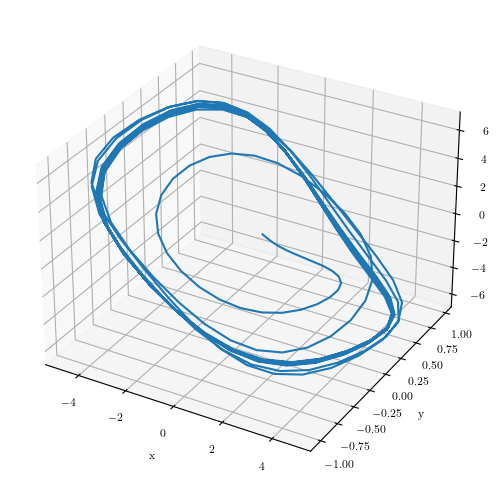

In [ ]:
# 3d-plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.plot(X_dot[0, :],X_dot[1, :], X_dot[2, :])
# plt.savefig('mod_chua_dynamics.jpg')
plt.show()

In [3]:
# energy landscape

W_mod_chua = np.linspace(0.7, 3, 100)
loss_sindy_mod_chua = []

for i in range(len(W_mod_chua)):
    psi_x_exp = psi_params_mod_chua(X, W_mod_chua[i]) 
    Xi_exp = sindy(X, X_dot, psi_x_exp)
    c = cost_sindy(Xi_exp, X_dot, psi_x_exp)
    loss_sindy_mod_chua.append(c)

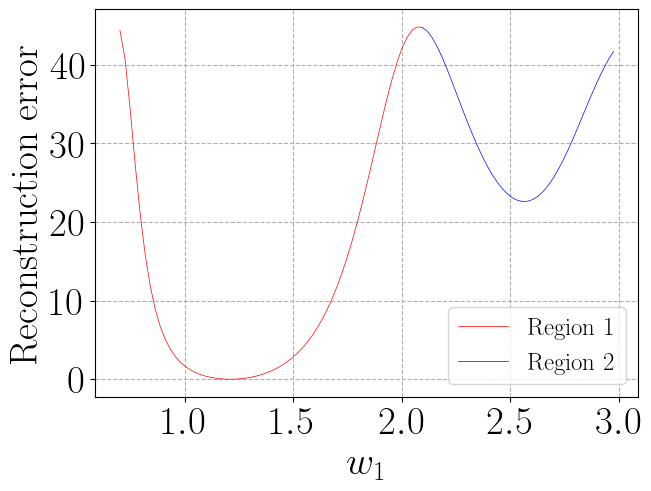

In [4]:
plt.figure()
start_1, end_1 = 0, 61 #np.where(W_mod_chua == 1), np.where(W_mod_chua == 1.8)
start_2, end_2 = 60, 99
# Plot each segment with different colors
plt.plot(W_mod_chua[start_1:end_1], loss_sindy_mod_chua[start_1:end_1], label='Region 1', linewidth=0.5, color='red')
plt.plot(W_mod_chua[start_2:end_2], loss_sindy_mod_chua[start_2:end_2], label='Region 2', linewidth=0.5, color='blue')

plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel(r'$w_1$', fontsize=28)
plt.ylabel('Reconstruction error', fontsize=28)
plt.legend(fontsize=18, loc='lower right')
# plt.savefig('Mod_chua_energy.pdf')
plt.show()

In [5]:
# Calling optimal sindy class

epss = 1e-28
loops = 100

opt_param_sindy = OptimalSindyODE(epss, loops, psi_params_mod_chua)

# GD hyper-parameters

W_init = np.array([1.9])   # Initial basis parameter

# Initial Psi matrix

psi_x_init = psi_params_mod_chua(X, W_init)
Psi_init = opt_param_sindy.sindy(X, X_dot, psi_x_init)

D = psi_x_init@psi_x_init.T                         # C is the hessian of the main function 
e = np.linalg.eig(D)                                # eigenvalues and eigenvectors of hessian 
L = np.max(e[0])                                    # e[0] is the array of eigenvalues and L is maximum eigenvalue

# step size
hs = 1/L
hw = hs
print(hs)

7.460039540540828e-06


In [9]:
# Alternating GD results for Chua's circuit

# GD

opt_xi_gd, W_gd, f_vals_gd_psi, f_vals_gd_w = opt_param_sindy.gradient_descent(W_init, Psi_init, X, X_dot, hw, hs, alt_loops=100)

# SGD

opt_xi_sgd, W_sgd, f_vals_sgd_psi, f_vals_sgd_w = opt_param_sindy.stochastic_gradient_descent(W_init, Psi_init, X, X_dot, hw, hs, batch_size=500, alt_loops=100)

# Nesterov

opt_xi_nest, W_nest, f_vals_nest_psi, f_vals_nest_w = opt_param_sindy.nesterov(W_init, Psi_init, X, X_dot, hw, hs, alt_loops=100)

# # Adam

opt_xi_adam, W_adam, f_vals_adam_psi, f_vals_adam_w = opt_param_sindy.adam(W_init, Psi_init, X, X_dot, hw=0.01, hs=0.01, alt_loops=100)

In [10]:
W_adam

Array([1.2089111], dtype=float32)

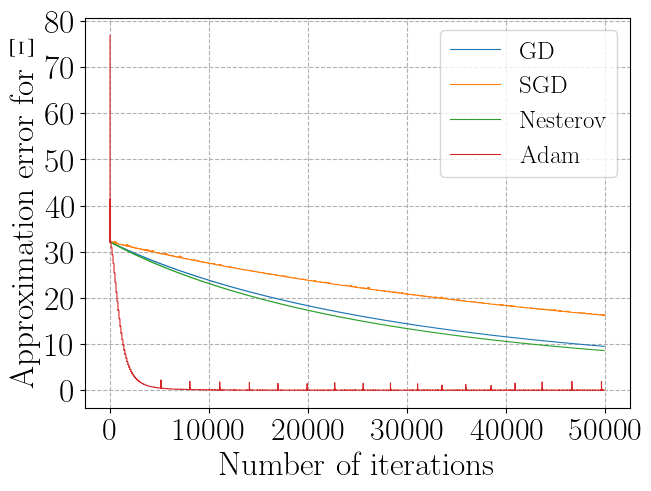

In [25]:
plt.figure()
plt.plot(f_vals_gd_psi, linewidth=0.8, label='GD')
plt.plot(f_vals_sgd_psi, linewidth=0.8, label='SGD')
plt.plot(f_vals_nest_psi, linewidth=0.8, label='Nesterov')
plt.plot(f_vals_adam_psi, linewidth=0.8, label='Adam')
plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.ylabel(r'Approximation error for $\Xi$', fontsize=24)
plt.xlabel('Number of iterations', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=23)
plt.yticks(fontsize=24)
# plt.savefig('loss_mod_chua_psi.pdf')
plt.show()

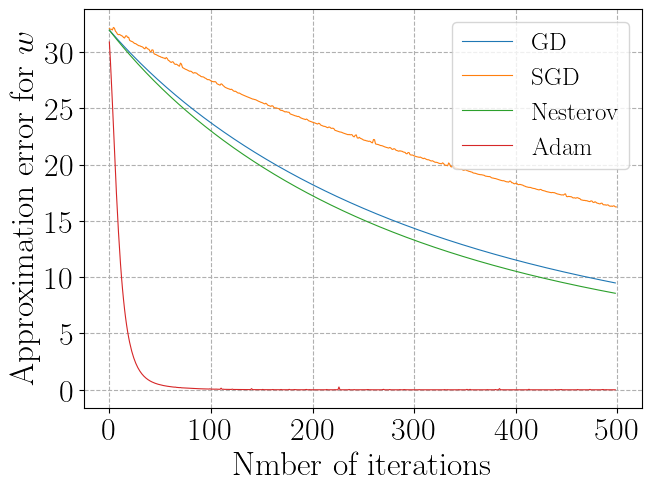

In [26]:
plt.figure()
plt.plot(f_vals_gd_w, linewidth=0.8, label='GD')
plt.plot(f_vals_sgd_w, linewidth=0.8, label='SGD')
plt.plot(f_vals_nest_w, linewidth=0.8, label='Nesterov')
plt.plot(f_vals_adam_w, linewidth=0.8, label='Adam')
plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.ylabel(r'Approximation error for $w$', fontsize=24)
plt.xlabel('Nmber of iterations', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
# plt.savefig('loss_mod_chua_w.pdf')
plt.show()

In [21]:
# Reconstruction from SINDy with exact basis

psi_x = psi_params_mod_chua(X, np.array([1.2]))
Xi_mod_chua = sindy(X, X_dot, psi_x)
Dy = Xi_mod_chua @ psi_x

In [22]:
# Reconstruction of the dynamics from Adam

psiX_p_gd = psi_params_mod_chua(X, W_adam)
Dy_gd = opt_xi_adam @ psiX_p_gd

In [23]:
# Reconstruction using a local minimum 

psiX_loc = psi_params_mod_chua(X, np.array([2.6]))
Dy_loc = opt_xi_adam @ psiX_loc

C:\Users\tabis\AppData\Local\Temp\ipykernel_8132\400579478.py:16: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('C:/Users/tabis/Desktop/PhD_second_year/Koopman_gradient_optimization/SINDy_experiments/SINDy_ode/Figures/mod_chua_reconstruction.pdf')


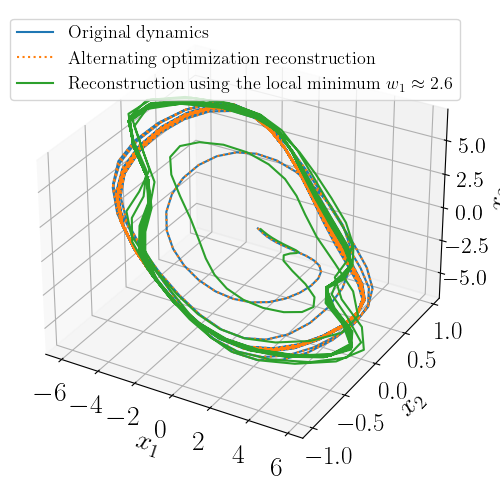

In [24]:
# 3d-plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$x_1$', fontsize=20)
ax.set_ylabel(r'$x_2$', fontsize=20)
ax.set_zlabel(r'$x_3$', fontsize=20)

#ax.plot(Dy[0, :], Dy[1, :], Dy[2, :], label='SINDy reconstruction')
ax.plot(X_dot[0,:], X_dot[1,:], X_dot[2,:],label='Original dynamics')
ax.plot(Dy_gd[0,:], Dy_gd[1,:], Dy_gd[2,:], ":", label='Alternating optimization reconstruction')
ax.plot(Dy_loc[0,:], Dy_loc[1,:], Dy_loc[2,:], label=r'Reconstruction using the local minimum $w_1 \approx 2.6$')
ax.legend(loc='upper right', fontsize=13)
plt.xticks(fontsize=20)
plt.yticks(np.linspace(-1, 1, 5), fontsize=18)
ax.tick_params(axis='z', labelsize=16)  # Adjust z-tick label size
# plt.savefig('mod_chua_reconstruction.pdf')
plt.show()


In [6]:
## Experiment comparing standard SINDy and parametric SINDy

w_exp_list = np.linspace(0.7, 3.0, 30)
error_p_sindy = np.zeros_like(w_exp_list)

for i in range(len(w_exp_list)):
    # error for parametric sindy
    psi_x_init_exp = psi_params_mod_chua(X, w_exp_list[i])
    Psi_init_exp = opt_param_sindy.sindy(X, X_dot, psi_x_init_exp)
    opt_xi_exp, W_exp, _, _ = opt_param_sindy.adam(w_exp_list[i], Psi_init_exp, X, X_dot, hw=0.01, hs=0.01, alt_loops=100)
    psi_x_exp = psi_params_mod_chua(X, W_exp) 
    c = cost_sindy(opt_xi_exp, X_dot, psi_x_exp)
    error_p_sindy[i] = c

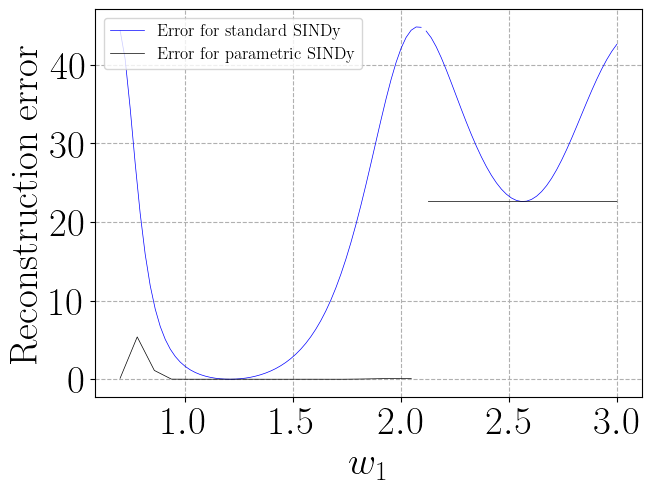

In [30]:
plt.figure()
sep1 = W_mod_chua < 2.1 
sep2 = w_exp_list < 2.1
# Plot each segment with different colors
#plt.plot(W_mod_chua[start_1:end_1], loss_sindy_mod_chua[start_1:end_1], linewidth=0.5, color='red')
plt.plot(W_mod_chua[sep1], np.array(loss_sindy_mod_chua)[sep1], linewidth=0.5, label='Error for standard SINDy', color='blue')
plt.plot(W_mod_chua[~sep1], np.array(loss_sindy_mod_chua)[~sep1], linewidth=0.5, color='blue')
plt.plot(w_exp_list[sep2], error_p_sindy[sep2], linewidth=0.5, color='black', label='Error for parametric SINDy')
plt.plot(w_exp_list[~sep2], error_p_sindy[~sep2], linewidth=0.5, color='black')
plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linestyle='--')
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel(r'$w_1$', fontsize=28)
plt.ylabel('Reconstruction error', fontsize=28)
plt.legend(fontsize=12, loc='upper left')
plt.savefig('sindy_ode_comparison.pdf')
plt.show()

In [25]:
error_p_sindy

array([1.17752378e-01, 5.38132250e+00, 1.11720582e+00, 1.09126632e-02,
       1.48817110e-03, 8.73290057e-04, 6.12890499e-03, 4.97756634e-03,
       6.58710583e-04, 3.11110952e-04, 8.49654842e-04, 2.77424210e-03,
       6.50369290e-04, 1.57912828e-04, 2.34195488e-02, 6.11054809e-02,
       9.81986143e-02, 9.78812724e-02, 2.26060526e+01, 2.26058634e+01,
       2.26043918e+01, 2.26108750e+01, 2.26069151e+01, 2.26050811e+01,
       2.26160123e+01, 2.26114009e+01, 2.26125040e+01, 2.26077647e+01,
       2.26044783e+01, 2.26055973e+01])